# Bike Sharing Demand Dataset

## Import Library: 분석에 사용할 모듈 설치

In [1]:
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_rows = 30
pd.options.display.max_columns = 20

plt.style.use("dark_background")

## Data Loading: 분석에 사용할 데이터 불러오기
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals
- Source: https://www.kaggle.com/c/bike-sharing-demand/data

In [34]:
raw_data = pd.read_csv("./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv")

## Feature Engineering: 데이터에서 시계열패턴 추출하기

In [35]:
data = raw_data
data["datetime"] = pd.to_datetime(data["datetime"])
data = data.set_index("datetime", drop=False)

### Set Frequency

In [37]:
data = data.asfreq("H", method="ffill")

### Split Data as Trend + Seasonal + Residual

In [38]:
# plt.rcParams["figure.figsize"] = (14, 11)
# decomp = sm.tsa.seasonal_decompose(data["count"], model="additive")
# decomp.plot()
# plt.show()

In [39]:
# decomp = sm.tsa.seasonal_decompose(data["count"], model="multiplicative")
# decomp.plot()
# plt.show()

In [40]:
decomp = sm.tsa.seasonal_decompose(data["count"], model="additive")

y_trend = pd.DataFrame(decomp.trend)
y_trend.columns = ["count_trend"]
y_trend.fillna(method="ffill", inplace=True)
y_trend.fillna(method="bfill", inplace=True)

y_seasonal = pd.DataFrame(decomp.seasonal)
y_seasonal.columns = ["count_seasonal"]
y_seasonal.fillna(method="ffill", inplace=True)
y_seasonal.fillna(method="bfill", inplace=True)

data = pd.concat([data, y_trend, y_seasonal], axis=1)

### Moving Average

In [41]:
y_roll_day = data[["count"]].rolling(24).mean()
y_roll_day.columns = ["count_day"]
y_roll_day.fillna(method="ffill", inplace=True)
y_roll_day.fillna(method="bfill", inplace=True)

y_roll_week = data[["count"]].rolling(24*7).mean()
y_roll_week.columns = ["count_week"]
y_roll_week.fillna(method="ffill", inplace=True)
y_roll_week.fillna(method="bfill", inplace=True)

data = pd.concat([data, y_roll_day, y_roll_week], axis=1)

### Difference

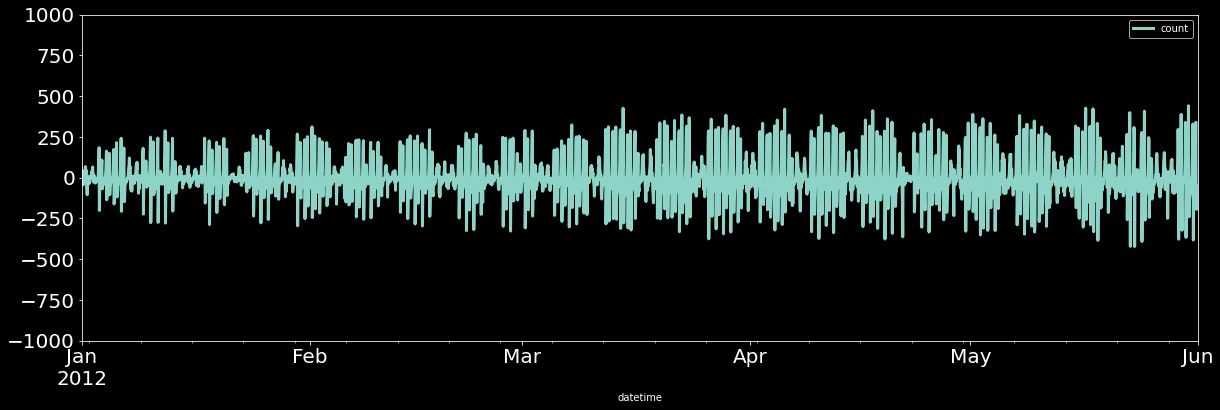

In [44]:
y_diff = data[["count"]].diff()
y_diff.plot(kind="line", figsize=(20,6), linewidth=3, fontsize=20, xlim=("2012-01-01", "2012-06-01"), ylim=(-1000,1000))
plt.show()

In [45]:
y_diff = data[["count"]].diff()
y_diff.columns = ["count_diff"]
y_diff = y_diff.fillna(method="ffill")
y_diff = y_diff.fillna(method="bfill")
data = pd.concat([data, y_diff], axis=1)

### Categorize

In [46]:
data["year"] = data["datetime"].dt.year
data["quarter"] = data["datetime"].dt.quarter
data["quarter2"] = data["quarter"]*(data["year"] - data["year"].min() + 1)
data["month"] = data["datetime"].dt.month
data["day"] = data["datetime"].dt.day
data["hour"] = data["datetime"].dt.hour
data["dayofweek"] = data["datetime"].dt.dayofweek

### Create Lagged Variables

In [48]:
data["count_lag1"] = data["count"].shift(1)
data["count_lag2"] = data["count"].shift(2)

data["count_lag1"] = data["count_lag1"].fillna(method="bfill")
data["count_lag2"] = data["count_lag2"].fillna(method="bfill")

### Create Dummy Variables

In [49]:
data = pd.concat([data, pd.get_dummies(data["quarter"], prefix="quarter_dummy", drop_first=True)], axis=1)
data = data.drop(["quarter"], axis=1)

## Data Understanding(Descriptive Statistics and Getting Insight from Features

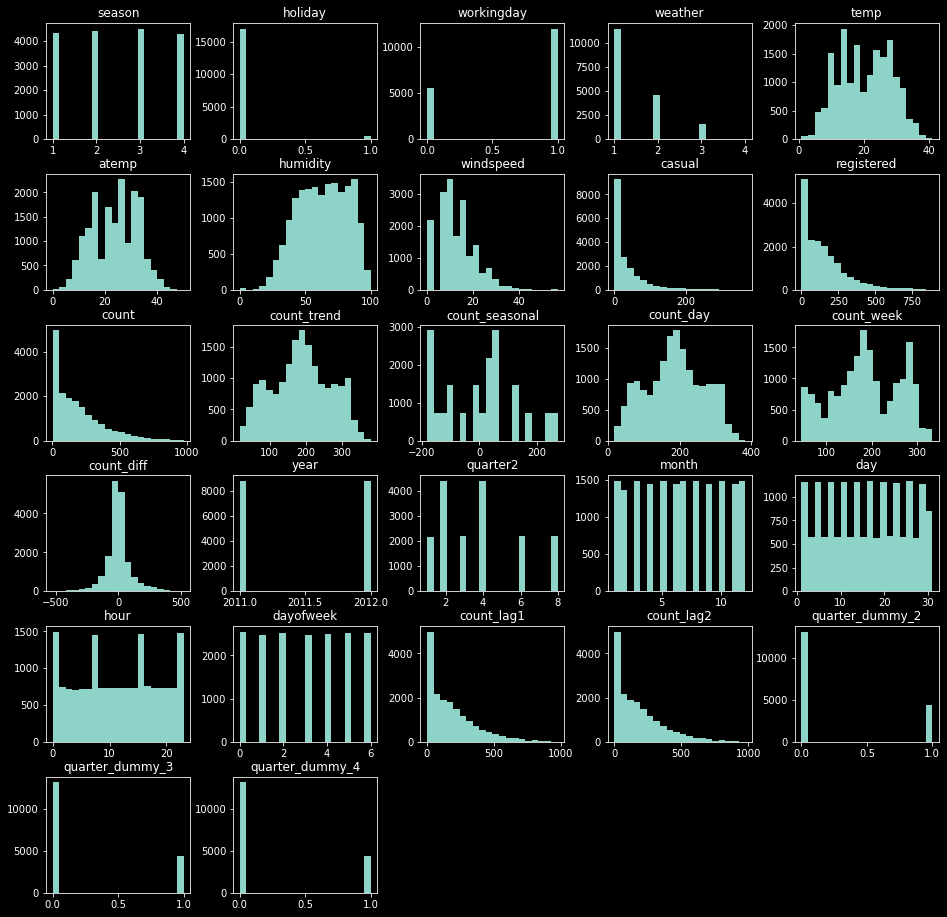

In [50]:
data.hist(bins=20, grid=False, figsize=(16, 16))
plt.show()

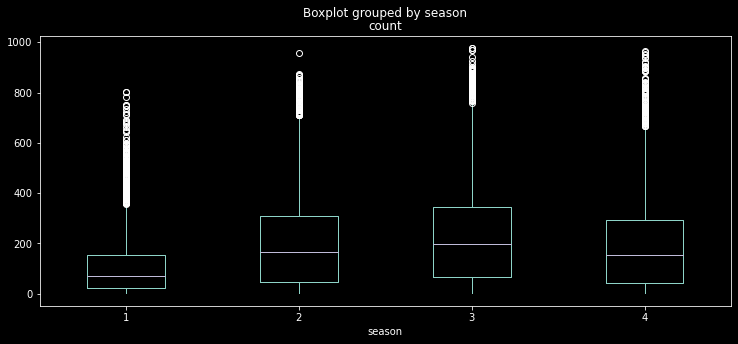

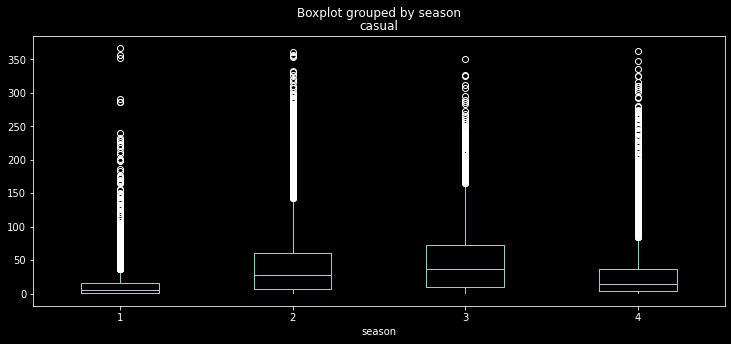

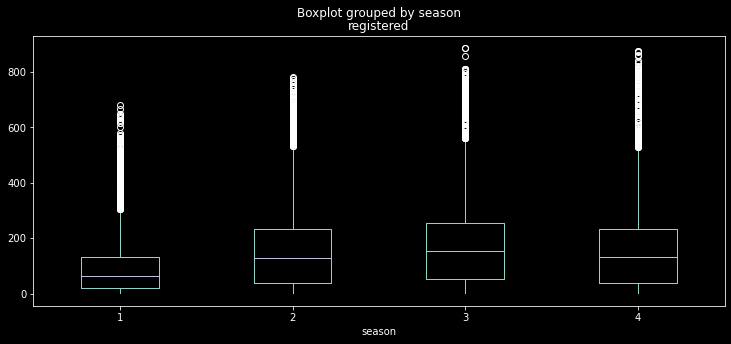

In [51]:
data.boxplot(column="count", by="season", grid=False, figsize=(12, 5))
data.boxplot(column="casual", by="season", grid=False, figsize=(12, 5))
data.boxplot(column="registered", by="season", grid=False, figsize=(12, 5))
plt.show()

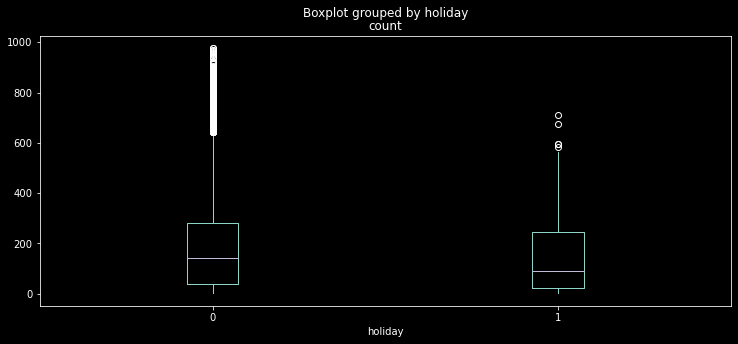

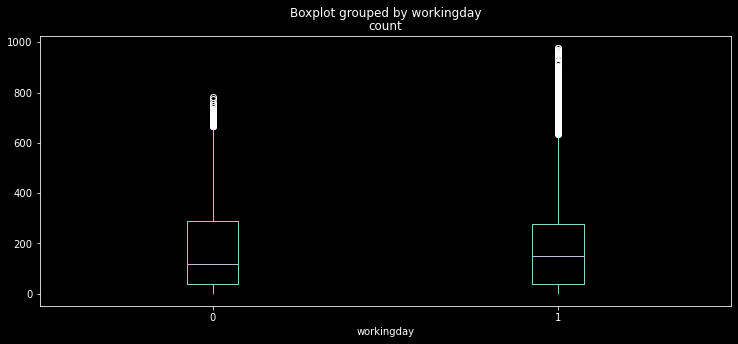

In [52]:
data.boxplot(column="count", by="holiday", grid=False, figsize=(12, 5))
data.boxplot(column="count", by="workingday", grid=False, figsize=(12, 5))
plt.show()

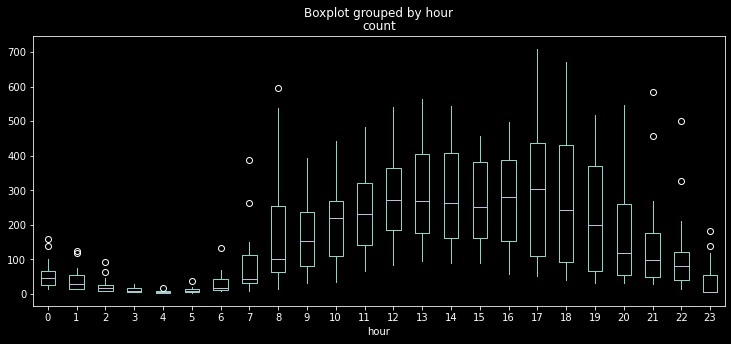

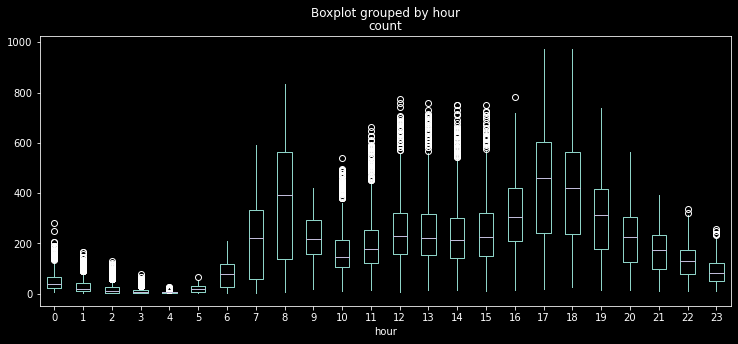

In [53]:
data[data.holiday == 1].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
data[data.holiday == 0].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
plt.show()

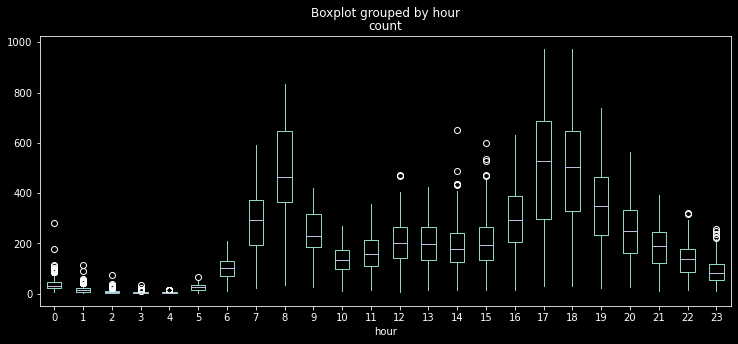

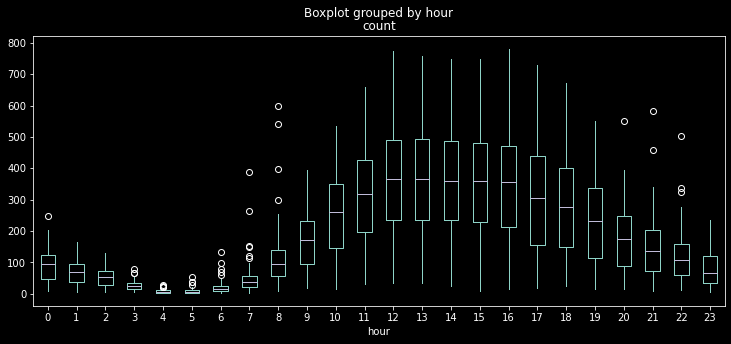

In [54]:
data[data.workingday == 1].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
data[data.workingday == 0].boxplot(column="count", by="hour", grid=False, figsize=(12, 5))
plt.show()

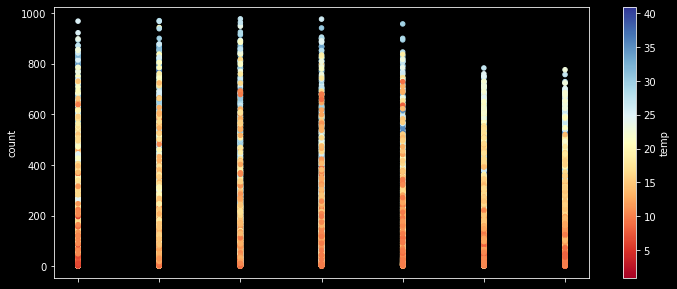

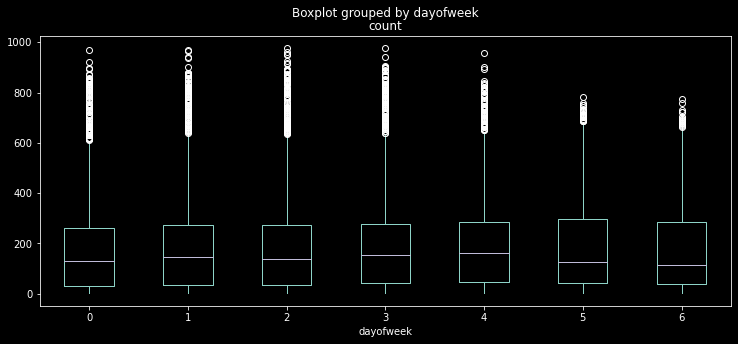

In [56]:
data.plot.scatter(y="count", x="dayofweek", c="temp", grid=False, figsize=(12, 5), cmap="RdYlBu")
data.boxplot(column="count", by="dayofweek", grid=False, figsize=(12, 5))
plt.show()

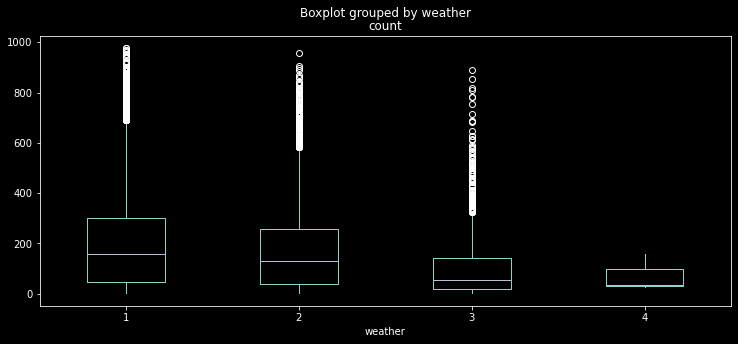

In [57]:
data.boxplot(column="count", by="weather", grid=False, figsize=(12, 5))
plt.show()

In [58]:
pd.crosstab(index=data["count"], columns=data["weather"], margins=True)

weather,1,2,3,4,All
count,,,,,
1,100,45,27,0,172
2,136,59,37,0,232
3,136,66,41,0,243
4,149,62,36,0,247
5,164,63,36,0,263
...,...,...,...,...,...
968,1,0,0,0,1
970,1,0,0,0,1
976,1,0,0,0,1


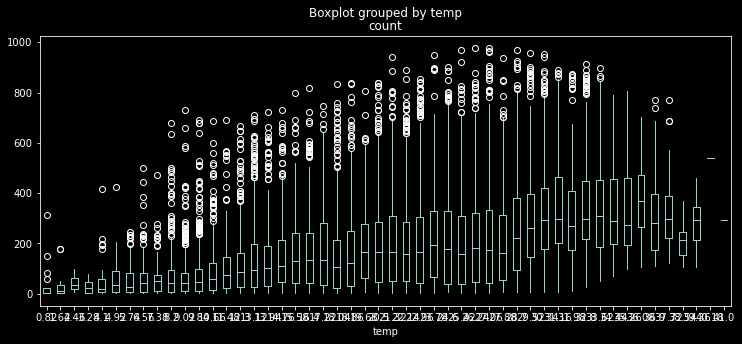

In [59]:
data.boxplot(column="count", by="temp", grid=False, figsize=(12, 5))
plt.show()

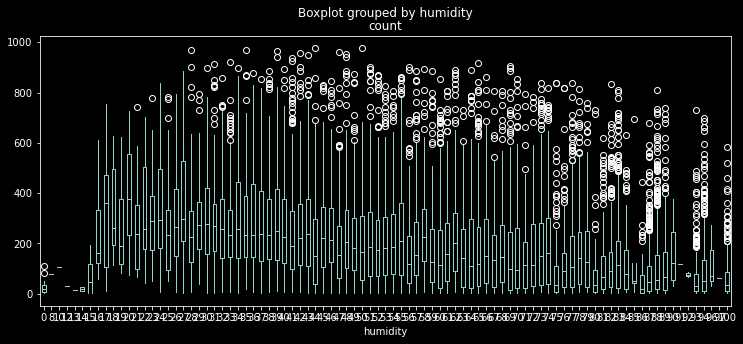

In [60]:
data.boxplot(column="count", by="humidity", grid=False, figsize=(12, 5))
plt.show()

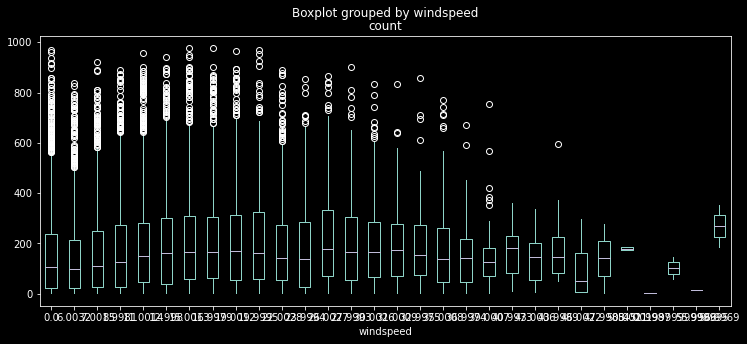

In [61]:
data.boxplot(column="count", by="windspeed", grid=False, figsize=(12, 5))
plt.show()

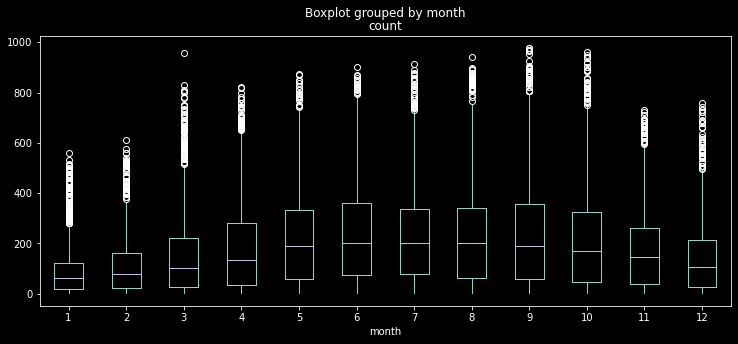

In [62]:
data.boxplot(column="count", by="month", grid=False, figsize=(12, 5))
plt.show()

In [63]:
# pd.plotting.scatter_matrix(data, figsize=(18, 18), diagonal="kde")
# plt.show()

<img src="Image/Scatter_Matrix.png" width="800">

In [64]:
data.corr().style.background_gradient(cmap="Blues").set_precision(1).set_properties(**{"font-size":"9pt"})

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,count_trend,count_seasonal,count_day,count_week,count_diff,year,quarter2,month,day,hour,dayofweek,count_lag1,count_lag2,quarter_dummy_2,quarter_dummy_3,quarter_dummy_4
season,1.0,-0.0,0.0,-0.0,0.3,0.3,0.1,-0.1,0.1,0.2,0.2,0.4,0.0,0.4,0.5,-0.0,-0.0,0.7,0.8,-0.0,-0.0,-0.0,0.2,0.2,-0.2,0.3,0.6
holiday,-0.0,1.0,-0.3,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.1,-0.0,-0.1,-0.0,-0.1,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.2,-0.0,-0.0,-0.0,-0.0,0.0
workingday,0.0,-0.3,1.0,0.0,0.1,0.1,0.0,-0.0,-0.3,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.7,0.0,0.0,0.0,0.0,-0.0
weather,-0.0,-0.0,0.0,1.0,-0.1,-0.1,0.4,0.0,-0.2,-0.1,-0.2,-0.3,-0.0,-0.2,-0.1,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.0,-0.1,0.1
temp,0.3,-0.0,0.1,-0.1,1.0,1.0,-0.1,-0.0,0.5,0.3,0.4,0.6,0.2,0.6,0.6,-0.0,0.0,0.2,0.2,0.0,0.1,-0.0,0.4,0.4,0.3,0.6,-0.3
atemp,0.3,-0.0,0.1,-0.1,1.0,1.0,-0.1,-0.1,0.5,0.3,0.4,0.6,0.2,0.6,0.6,-0.0,0.0,0.2,0.2,0.0,0.1,-0.0,0.4,0.4,0.3,0.6,-0.3
humidity,0.1,-0.0,0.0,0.4,-0.1,-0.1,1.0,-0.3,-0.3,-0.3,-0.3,-0.1,-0.3,-0.1,0.0,0.0,-0.1,0.1,0.2,0.0,-0.3,-0.0,-0.3,-0.3,-0.0,0.1,0.1
windspeed,-0.1,0.0,-0.0,0.0,-0.0,-0.1,-0.3,1.0,0.1,0.1,0.1,-0.2,0.2,-0.1,-0.1,0.0,-0.0,-0.1,-0.1,0.0,0.1,-0.0,0.1,0.1,0.0,-0.1,-0.1
casual,0.1,0.0,-0.3,-0.2,0.5,0.5,-0.3,0.1,1.0,0.5,0.7,0.4,0.4,0.4,0.3,0.1,0.1,0.1,0.1,-0.0,0.3,0.2,0.7,0.6,0.1,0.2,-0.1
registered,0.2,-0.1,0.1,-0.1,0.3,0.3,-0.3,0.1,0.5,1.0,1.0,0.4,0.7,0.4,0.4,0.3,0.3,0.2,0.1,-0.0,0.4,-0.1,0.8,0.5,0.1,0.1,-0.0


In [65]:
data.corr().loc[:, ["casual", "registered", "count"]].style.background_gradient().set_precision(2).set_properties(**{"font-size": "10pt"})

,casual,registered,count
season,0.12,0.18,0.18
holiday,0.03,-0.05,-0.04
workingday,-0.30,0.13,0.03
weather,-0.16,-0.13,-0.15
temp,0.46,0.34,0.41
atemp,0.46,0.34,0.41
humidity,-0.35,-0.28,-0.33
windspeed,0.08,0.07,0.08
casual,1.00,0.51,0.70
registered,0.51,1.00,0.97


## Data Split: 최종 전처리 및 학습/검증/테스트용 데이터 분리

In [66]:
tr = data[data.index < "2012-07-01"]
test = data[data.index >= "2012-07-01"]
y_cols = ["count"]
x_cols = [x for x in data.columns if x not in ["datetime", "casual", "registered"] + y_cols]
x_tr = tr[x_cols]
y_tr = tr[y_cols]
x_test = test[x_cols]
y_test = test[y_cols]

## Applying Base Model

In [67]:
fit_reg1 = sm.OLS(y_tr, x_tr).fit()
fit_reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.666e+08
Date:                Wed, 04 Aug 2021   Prob (F-statistic):                        0.00
Time:                        22:53:38   Log-Likelihood:                          1906.4
No. Observations:               13128   AIC:                                     -3765.
Df Residuals:                   13104   BIC:                                     -3585.
Df Model:                          24                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
season             -0.0017      0.004     -0.409      0.683      -0.010       0.006
holiday             0.0084      0.014      0.619      0.536      -0.018       0.035
workingday          0.0079      0.007      1.191      0.234      -0.005       0.021
weather             0.0046      0.003      1.339      0.181      -0.002       0.011
temp                0.0021      0.002      1.003      0.316      -0.002       0.006
atemp              -0.0025      0.002     -1.366      0.172      -0.006       0.001
humidity           -0.0001      0.000     -0.951      0.342      -0.000       0.000
windspeed           0.0003      0.000      1.088      0.277      -0.000       0.001
count_trend         0.0001   8.52e-05      1.214      0.225   -6.36e-05       0.000
count_seasonal   2.031e-05   2.56e-05      0.793      0.428   -2.99e-05    7.05e-05
count_day        3.943e-05   8.36e-05      0.471      0.637      -0.000       0.000
count_week        8.51e-06   9.37e-05      0.091      0.928      -0.000       0.000
count_diff          1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
year            -1.322e-05   8.26e-06     -1.600      0.110   -2.94e-05    2.98e-06
quarter2           -0.0038      0.005     -0.734      0.463      -0.014       0.006
month               0.0021      0.002      0.852      0.394      -0.003       0.007
day                 0.0004      0.000      1.741      0.082   -4.64e-05       0.001
hour                0.0006      0.000      1.554      0.120      -0.000       0.001
dayofweek           0.0003      0.002      0.205      0.837      -0.003       0.003
count_lag1          1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2      -1.861e-05   2.59e-05     -0.719      0.472   -6.93e-05    3.21e-05
quarter_dummy_2     0.0038      0.011      0.344      0.731      -0.018       0.026
quarter_dummy_3     0.0061      0.020      0.301      0.763      -0.034       0.046
quarter_dummy_4     0.0032      0.031      0.105      0.917      -0.057       0.064
==============================================================================
Omnibus:                    54425.106   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93537563761.725
Skew:                        -114.248   Prob(JB):                         0.00
Kurtosis:                   13077.740   Cond. No.                     4.25e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.25e+04. Th

In [68]:
pred_tr_reg1 = fit_reg1.predict(x_tr).values
pred_test_reg1 = fit_reg1.predict(x_test).values

## Evaluation

In [112]:
# pd.concat([Y_train, pd.DataFrame(pred_tr_reg1, index=Y_train.index, columns=["prediction"])], axis=1)

In [113]:
pd.concat([Y_train, pd.DataFrame(pred_tr_reg1, index=Y_train.index, columns=["prediction"])], axis=1)

,count,prediction
DateTime,,
2011-01-01 00:00:00,16,39.95
2011-01-01 01:00:00,40,39.96
2011-01-01 02:00:00,32,31.96
2011-01-01 03:00:00,13,12.96
2011-01-01 04:00:00,1,0.96
...,...,...
2012-06-30 19:00:00,374,374.00
2012-06-30 20:00:00,292,292.00
2012-06-30 21:00:00,213,213.00


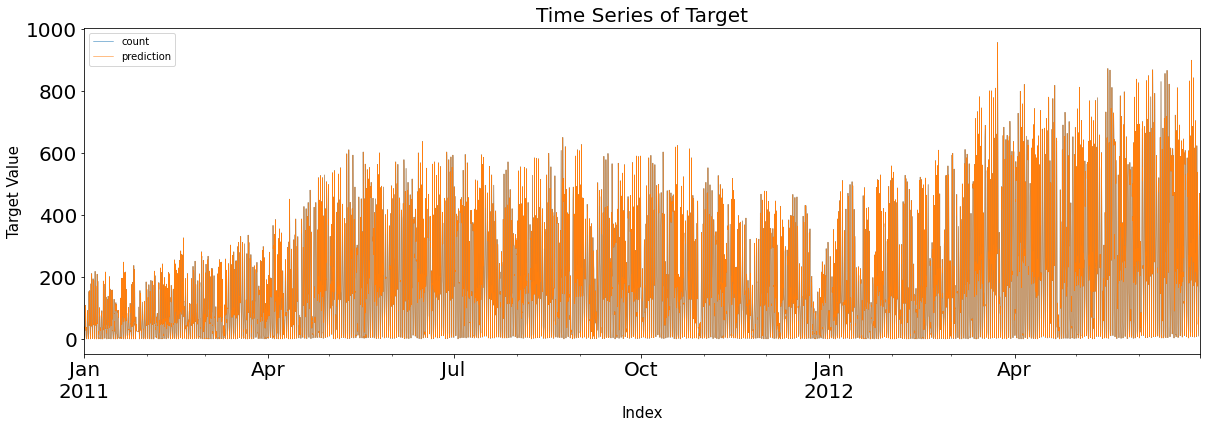

In [114]:
# precision comparisions
pd.concat([Y_train, pd.DataFrame(pred_tr_reg1, index=Y_train.index, columns=["prediction"])], axis=1).plot(kind="line", figsize=(20,6),
                                                                                                               xlim=(Y_train.index.min(),Y_train.index.max()),
                                                                                                               linewidth=0.5, fontsize=20)
plt.title("Time Series of Target", fontsize=20)
plt.xlabel("Index", fontsize=15)
plt.ylabel("Target Value", fontsize=15)
plt.show()

In [115]:
MAE = abs(Y_train.values.flatten() - pred_tr_reg1).mean()
MSE = ((Y_train.values.flatten() - pred_tr_reg1)**2).mean()
MAPE = (abs(Y_train.values.flatten() - pred_tr_reg1)/Y_train.values.flatten()*100).mean()
pd.DataFrame([MAE, MSE, MAPE], index=["MAE", "MSE", "MAPE"], columns=["Score"]).T

,MAE,MSE,MAPE
Score,0.01,0.04,0.06


In [116]:
MAE = abs(Y_train.values.flatten() - pred_tr_reg1).mean()
MSE = ((Y_train.values.flatten() - pred_tr_reg1)**2).mean()
MAPE = (abs(Y_train.values.flatten() - pred_tr_reg1)/Y_train.values.flatten()*100).mean()

display(pd.DataFrame([MAE, MSE, MAPE], index=["MAE", "MSE", "MAPE"], columns=["Score"]).T)

,MAE,MSE,MAPE
Score,0.01,0.04,0.06


## Code Summary

In [117]:
### Functionalize
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=["prediction"])], axis=1).plot(kind="line", figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title("Time Series of Target", fontsize=20)
        plt.xlabel("Index", fontsize=15)
        plt.ylabel("Target Value", fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=["MAE", "MSE", "MAPE"], columns=["Score"]).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=["Error"])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ["Train", "Test"]
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)

,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


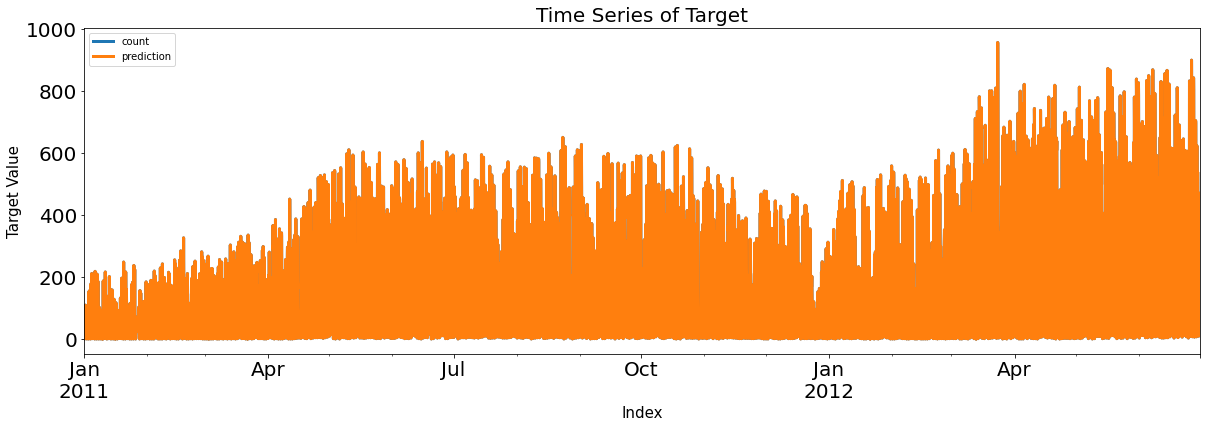

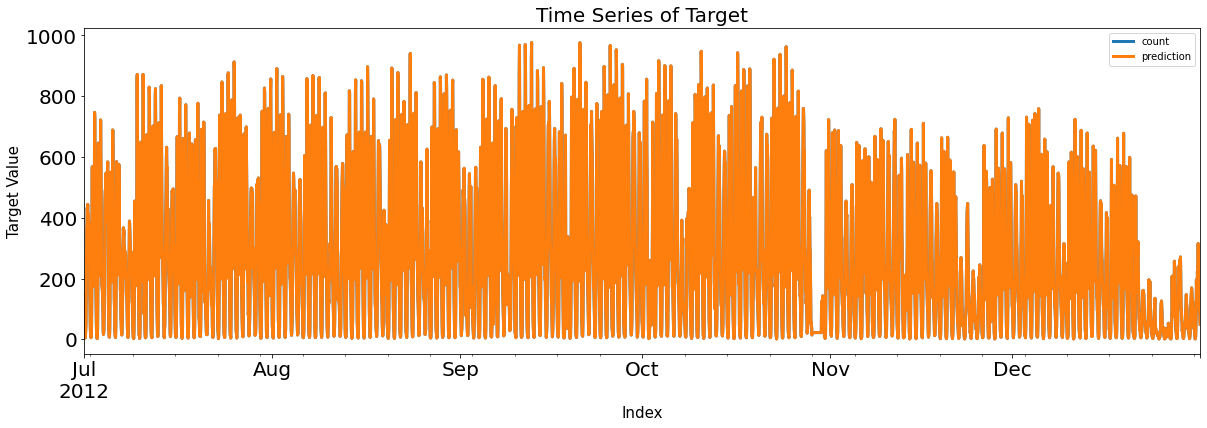

In [118]:
# results of evaluations
Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)
Score_reg1

# Error Analysis: 분석모형이 데이터패턴을 모두 추출하여 분석을 종료해도 되는지 판단하기
**1. Import Library**  
**2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
**3. Feature Engineering(Rearrange of Data)**  
**4. Data Understanding(Descriptive Statistics and Getting Insight from Features)**  
**5. Data Split: Train/Validate/Test Sets**  
**6. Applying Base Model**  
**7. Evaluation**  
**8. Error Analysis**  

In [119]:
# pd.Series(sm.tsa.stattools.adfuller(Resid_tr_reg1["Error"])
# sm.tsa.stattools.adfuller(Resid_tr_reg1["Error"])
# pd.Series(sm.tsa.stattools.adfuller(Resid_tr_reg1["Error"])[0:4], index=["Test Statistics", "p-value", "Used Lag", "Used Observations"])

In [120]:
Resid_tr_reg1["RowNum"] = Resid_tr_reg1.reset_index().index
Resid_tr_reg1

,Error,RowNum
DateTime,,
2011-01-01 00:00:00,-23.95,0
2011-01-01 01:00:00,0.04,1
2011-01-01 02:00:00,0.04,2
2011-01-01 03:00:00,0.04,3
2011-01-01 04:00:00,0.04,4
...,...,...
2012-06-30 19:00:00,-0.00,13123
2012-06-30 20:00:00,0.00,13124
2012-06-30 21:00:00,0.00,13125


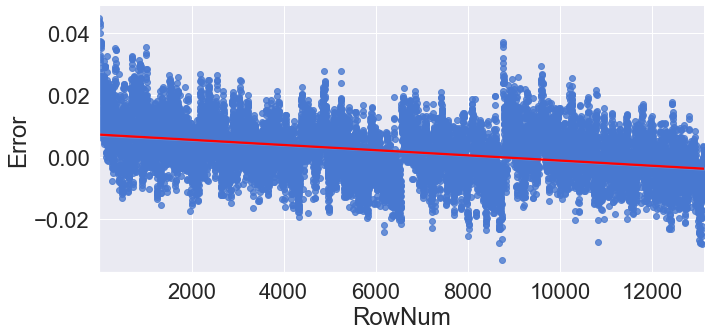

In [121]:
sns.set(palette="muted", color_codes=True, font_scale=2)
sns.lmplot(data=Resid_tr_reg1.iloc[1:], x="RowNum", y="Error",
           fit_reg=True, line_kws={"color": "red"}, size=5.2, aspect=2, ci=99, sharey=True)

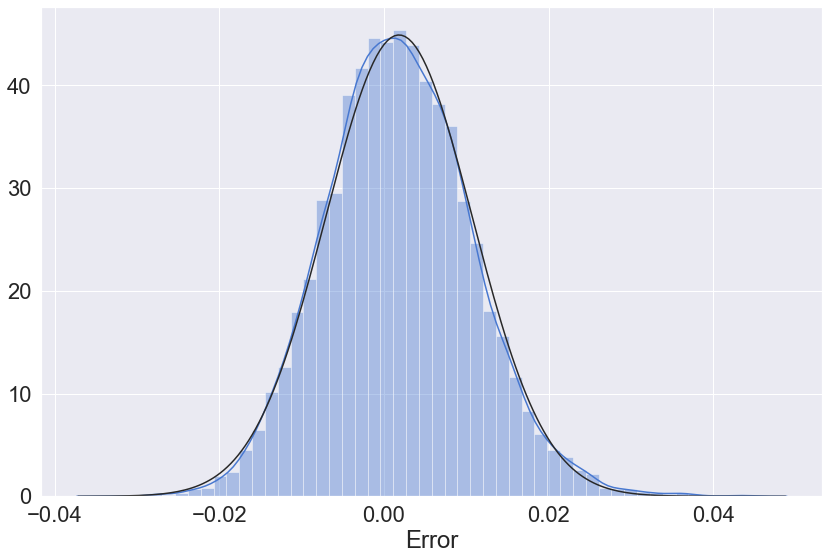

In [122]:
sns.distplot(Resid_tr_reg1["Error"].iloc[1:], norm_hist="True", fit=stats.norm)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

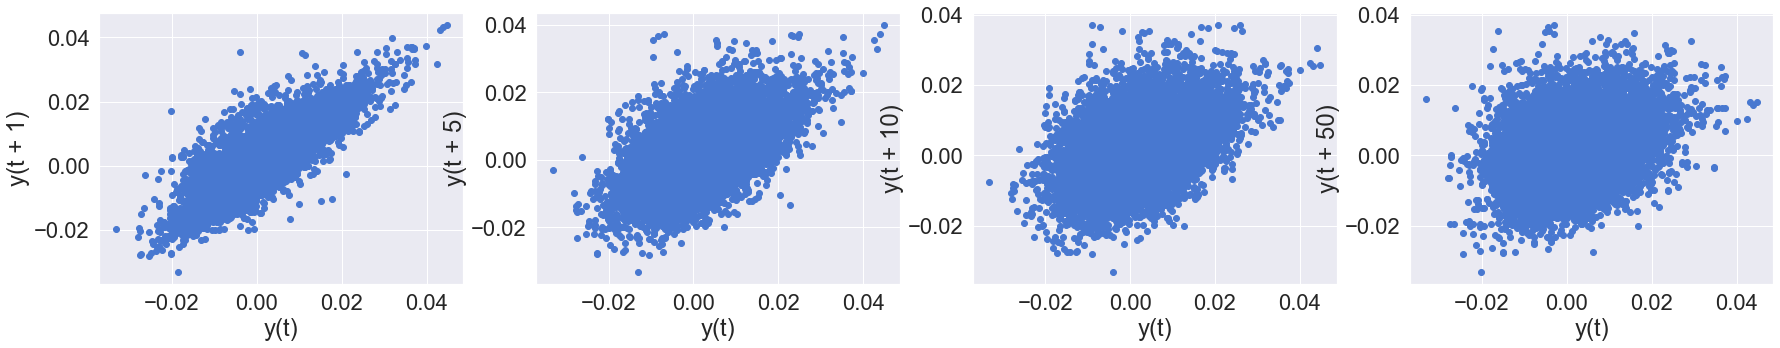

In [123]:
figure, axes = plt.subplots(1, 4, figsize=(30,5))
pd.plotting.lag_plot(Resid_tr_reg1["Error"].iloc[1:], lag=1, ax=axes[0])
pd.plotting.lag_plot(Resid_tr_reg1["Error"].iloc[1:], lag=5, ax=axes[1])
pd.plotting.lag_plot(Resid_tr_reg1["Error"].iloc[1:], lag=10, ax=axes[2])
pd.plotting.lag_plot(Resid_tr_reg1["Error"].iloc[1:], lag=50, ax=axes[3])

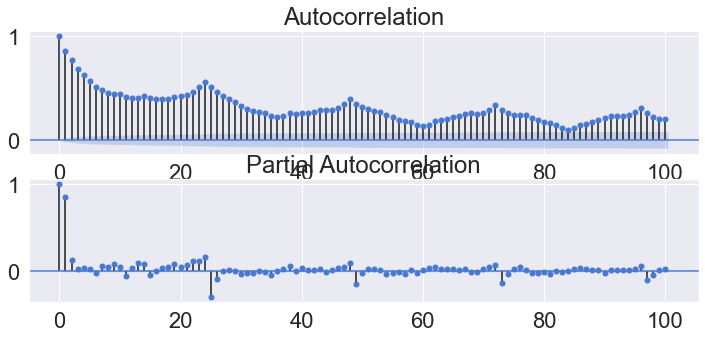

In [124]:
figure, axes = plt.subplots(2,1,figsize=(12, 5))
figure = sm.graphics.tsa.plot_acf(Resid_tr_reg1["Error"].iloc[1:], lags=100, use_vlines=True, ax=axes[0])
figure = sm.graphics.tsa.plot_pacf(Resid_tr_reg1["Error"].iloc[1:], lags=100, use_vlines=True, ax=axes[1])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.98,0.01,0.00,0.01,0.03,0.10,0.00
p-value,0.00,0.00,0.98,1.00,1.00,1.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),-2.86,nan,nan,nan,nan,nan,NaN
Critical Value(10%),-2.57,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,845.57",nan,nan,nan,nan,nan,NaN


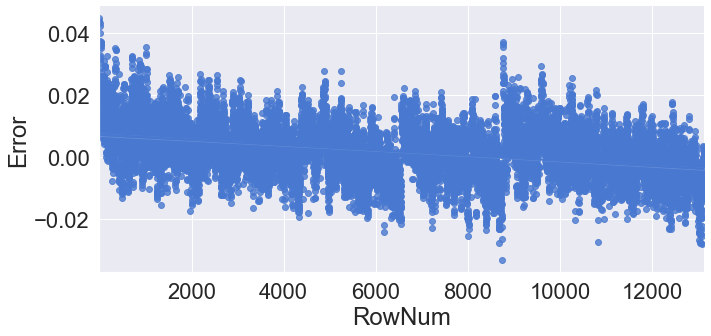

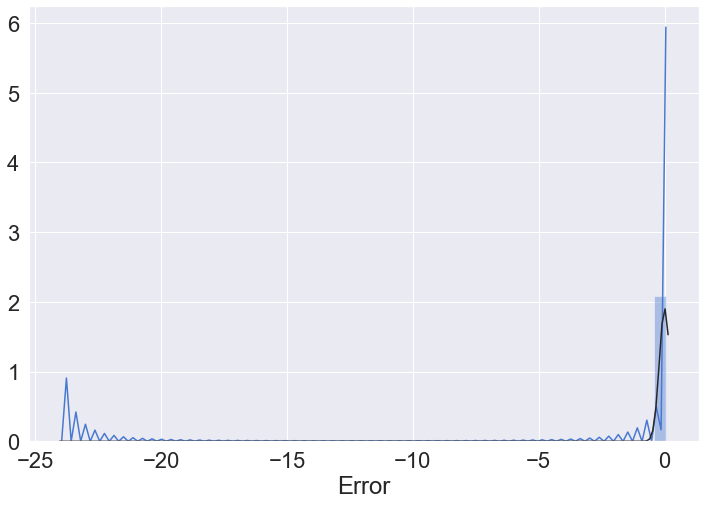

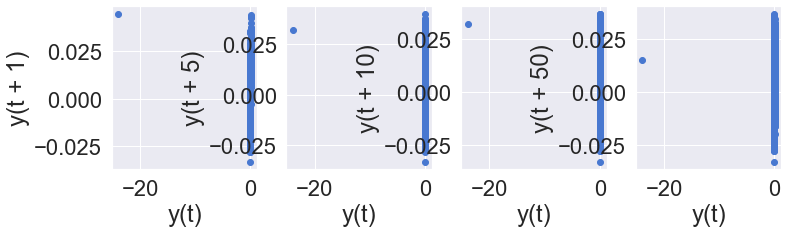

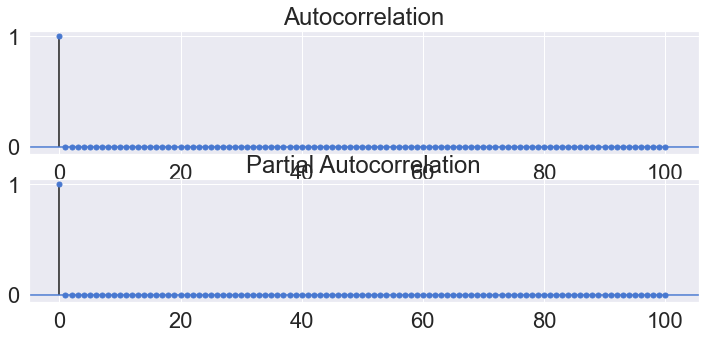

In [126]:
# Error Analysis(Plot)
Resid_tr_reg1["RowNum"] = Resid_tr_reg1.reset_index().index

# Stationarity(Trend) Analysis
sns.set(palette="muted", color_codes=True, font_scale=2)
sns.lmplot(x="RowNum", y="Error", data=Resid_tr_reg1.iloc[1:],
           fit_reg="True", size=5.2, aspect=2, ci=99, sharey=True)

# Normal Distribution Analysis
figure, axes = plt.subplots(figsize=(12,8))
sns.distplot(Resid_tr_reg1["Error"], norm_hist="True", fit=stats.norm)

# Lag Analysis
length = int(len(Resid_tr_reg1["Error"])/10)
figure, axes = plt.subplots(1, 4, figsize=(12,3))
pd.plotting.lag_plot(Resid_tr_reg1["Error"], lag=1, ax=axes[0])
pd.plotting.lag_plot(Resid_tr_reg1["Error"], lag=5, ax=axes[1])
pd.plotting.lag_plot(Resid_tr_reg1["Error"], lag=10, ax=axes[2])
pd.plotting.lag_plot(Resid_tr_reg1["Error"], lag=50, ax=axes[3])

# Autocorrelation Analysis
figure, axes = plt.subplots(2,1,figsize=(12, 5))
figure = sm.graphics.tsa.plot_acf(Resid_tr_reg1["Error"], lags=100, use_vlines=True, ax=axes[0])
figure = sm.graphics.tsa.plot_pacf(Resid_tr_reg1["Error"], lags=100, use_vlines=True, ax=axes[1])

# Error Analysis(Statistics)
# Checking Stationarity
# Null Hypothesis: The Time-series is non-stationalry
Stationarity = pd.Series(sm.tsa.stattools.adfuller(Resid_tr_reg1["Error"])[0:4], index=["Test Statistics", "p-value", "Used Lag", "Used Observations"])
for key, value in sm.tsa.stattools.adfuller(Resid_tr_reg1["Error"])[4].items():
    Stationarity["Critical Value(%s)"%key] = value
Stationarity["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Resid_tr_reg1["Error"])[5]
Stationarity = pd.DataFrame(Stationarity, columns=["Stationarity"])

# Checking of Normality
# Null Hypothesis: The residuals are normally distributed
Normality = pd.DataFrame([stats.shapiro(Resid_tr_reg1["Error"])], index=["Normality"], columns=["Test Statistics", "p-value"]).T

# Checking for Autocorrelation
# Null Hypothesis: Autocorrelation is absent
Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1["Error"], lags=[1,5,10,50])[0], columns=["Test Statistics"]),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1["Error"], lags=[1,5,10,50])[1], columns=["p-value"])], axis=1).T
Autocorrelation.columns = ["Autocorr(lag1)", "Autocorr(lag5)", "Autocorr(lag10)", "Autocorr(lag50)"]

# Checking Heteroscedasticity
# Null Hypothesis: Error terms are homoscedastic
Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Resid_tr_reg1["Error"], X_train.values, alternative="two-sided")],
                                  index=["Heteroscedasticity"], columns=["Test Statistics", "p-value", "Alternative"]).T
Error_Analysis = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join="outer", axis=1)
Error_Analysis = Error_Analysis.loc[["Test Statistics", "p-value", "Alternative", "Used Lag", "Used Observations",
                                     "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)",
                                     "Maximum Information Criteria"],:]
Error_Analysis

## Code Summary

In [127]:
### Functionalize
### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=["Test Statistics", "p-value", "Used Lag", "Used Observations"])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf["Critical Value(%s)"%key] = value
            Stationarity_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=["Stationarity_adf"])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=["Test Statistics", "p-value", "Used Lag", "Used Observations"])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf["Critical Value(%s)"%key] = value
            Stationarity_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=["Stationarity_adf"])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=["Test Statistics", "p-value", "Used Lag"])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss["Critical Value(%s)"%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=["Stationarity_kpss"])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=["Test Statistics", "p-value", "Used Lag"])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss["Critical Value(%s)"%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=["Stationarity_kpss"])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data["RowNum"] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x="RowNum", y=Target_name, data=Y_Data, fit_reg="True", size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data["RowNum"]

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist="True", fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12, 5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=["Normality"], columns=["Test Statistics", "p-value"]).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=["Test Statistics"]),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=["p-value"])], axis=1).T
    Autocorrelation.columns = ["Autocorr(lag1)", "Autocorr(lag5)", "Autocorr(lag10)", "Autocorr(lag50)"]

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative="two-sided")],
                                      index=["Heteroscedasticity"], columns=["Test Statistics", "p-value", "Alternative"]).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join="outer", axis=1)
    index_new = ["Test Statistics", "p-value", "Alternative", "Used Lag", "Used Observations",
                 "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)", "Maximum Information Criteria"]
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ["Error"], X_train, graph_on=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.98,0.09,0.01,0.00,0.01,0.03,0.10,0.00
p-value,0.00,0.10,0.00,0.98,1.00,1.00,1.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,845.57",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


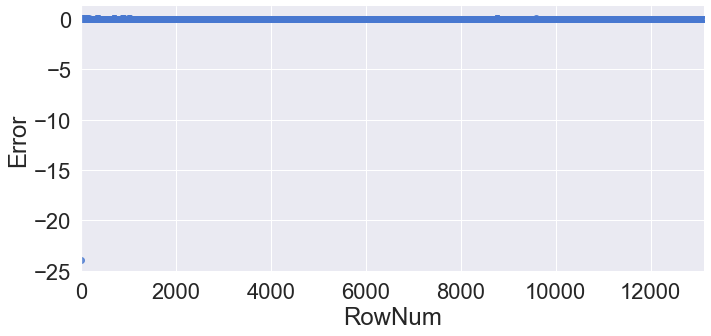

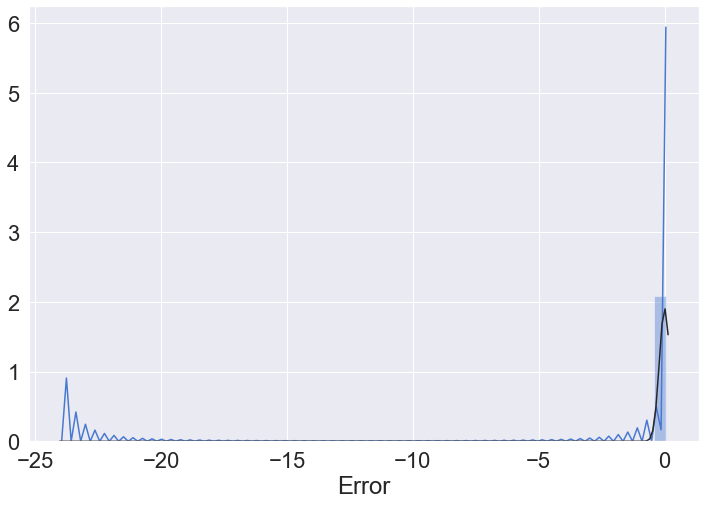

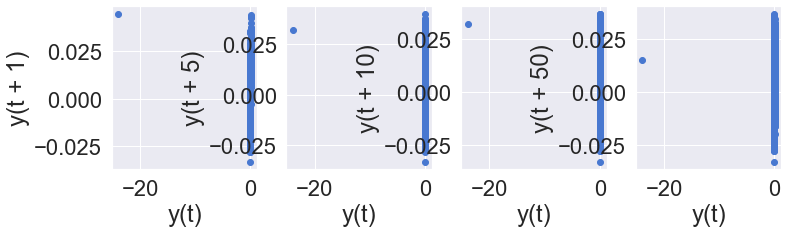

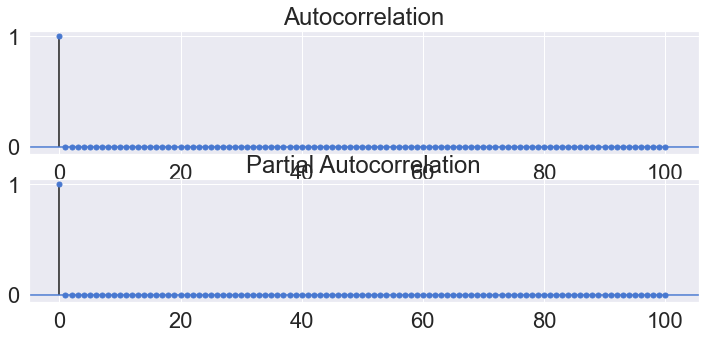

In [128]:
error_analysis(Resid_tr_reg1, ["Error"], X_train, graph_on=True)
# 정상성 / 비정규분포 / 자기상관없음 / 등분산아님

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.82,7.52,1.00,"9,615.96","32,903.39","47,262.88","116,653.97",2.10
p-value,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,085.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,838.93",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


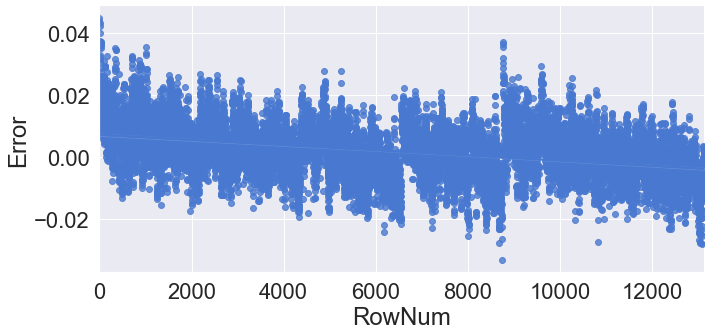

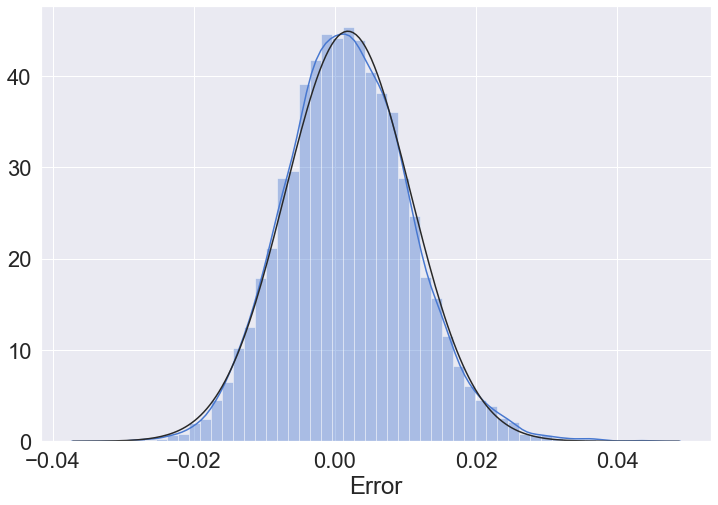

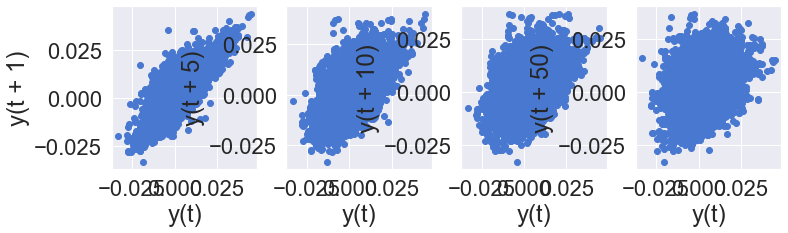

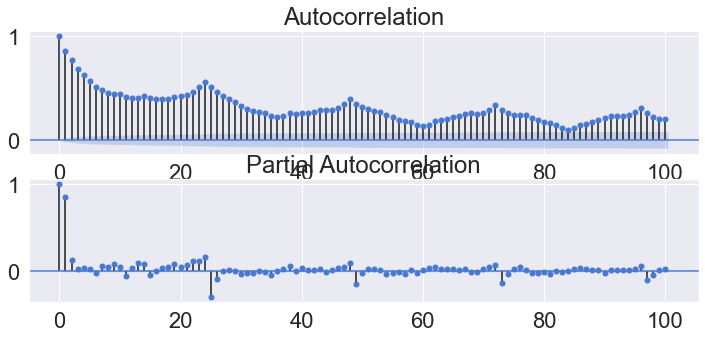

In [129]:
error_analysis(Resid_tr_reg1.iloc[1:], ["Error"], X_train, graph_on=True)
# 정상성(ADf) / 비정상성(KPSS) / 비정규분포 / 자기상관있음 / 등분산아님

# Summary: insufficient for me
**1) 데이터 핸들링**  

**2) 단계이해**  
>**1. Import Library**  
**2. Data Loading**  [(Data Source and Description)](https://www.kaggle.com/c/bike-sharing-demand/data)  
**3. Feature Engineering(Rearrange of Data)**  
**4. Data Understanding(Descriptive Statistics and Getting Insight from Features)**  
**5. Data Split: Train/Validate/Test Sets**  
**6. Applying Base Model**  
**7. Evaluation**  
**8. Error Analysis** 

**3) 결과 해석**  

## Code Summary (Raw Data)

Train_size: (13128, 12) Test_size: (4416, 12)
X_train: (13128, 8) Y_train: (13128, 1)
X_test: (4416, 8) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  count   R-squared (uncentered):                   0.638
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              2889.
Date:                Mon, 14 Sep 2020   Prob (F-statistic):                        0.00
Time:                        23:23:47   Log-Likelihood:                         -83421.
No. Observations:               13128   AIC:                                  1.669e+05
Df Residuals:                   13120   BIC:                                  1.669e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
season         3.3659      1.286      2.618      0.009       0.846       5.886
holiday       -6.2896      7.466     -0.842      0.400     -20.924       8.345
workingday    10.3553      2.641      3.921      0.000       5.178      15.533
weather        7.1906      2.093      3.436      0.001       3.089      11.292
temp          -7.8544      1.222     -6.429      0.000     -10.249      -5.460
atemp         16.0695      1.095     14.676      0.000      13.923      18.216
humidity      -1.7353      0.063    -27.356      0.000      -1.860      -1.611
windspeed      2.2749      0.136     16.745      0.000       2.009       2.541
==============================================================================
Omnibus:                     2168.771   Durbin-Watson:                   0.419
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3942.747
Skew:                           1.050   Prob(JB):                         0.00
Kurtosis:                       4.672   Cond. No.                         450.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,MAE,MSE,MAPE
Train,103.09,"19,360.42",458.48
Test,150.03,"43,410.27",316.61


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.25,11.19,0.94,"8,204.84","12,494.43","13,138.03","48,485.56",1.76
p-value,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,40.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,087.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"143,252.82",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


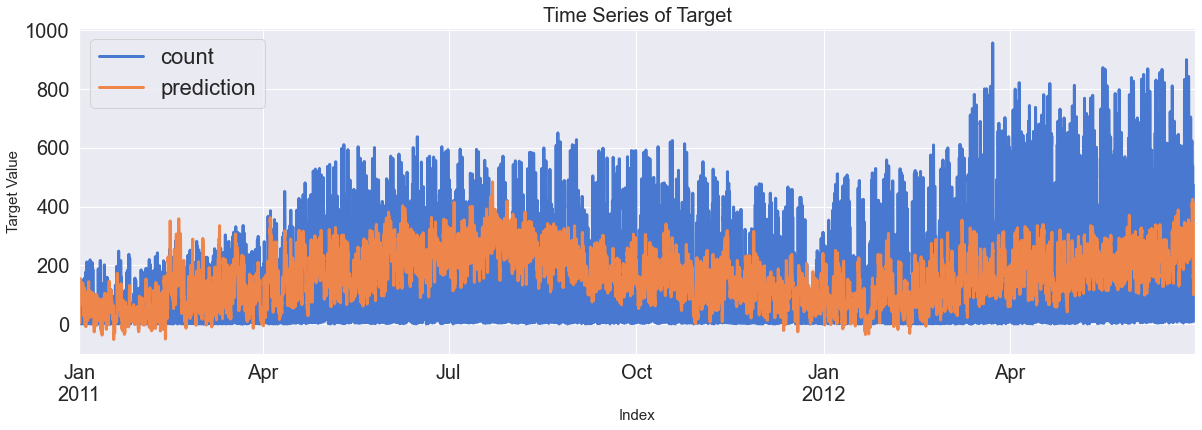

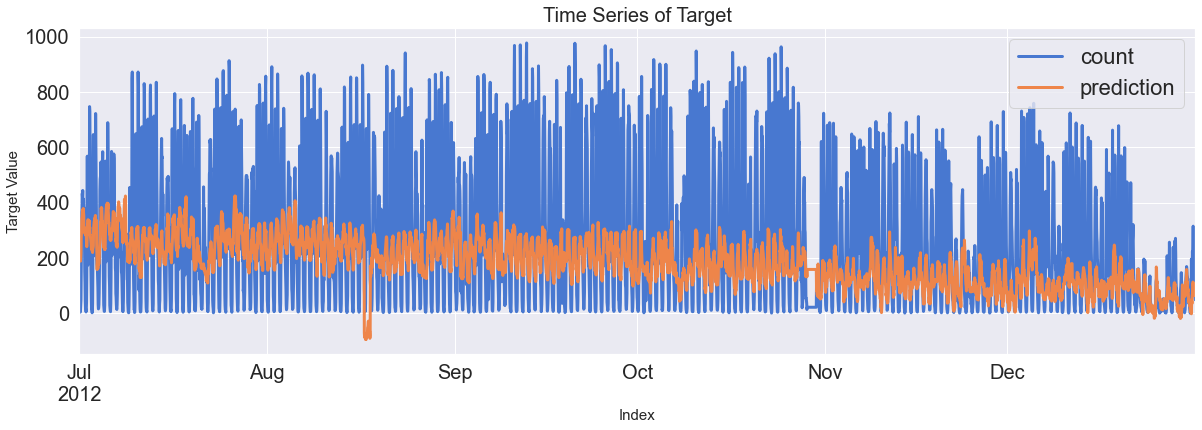

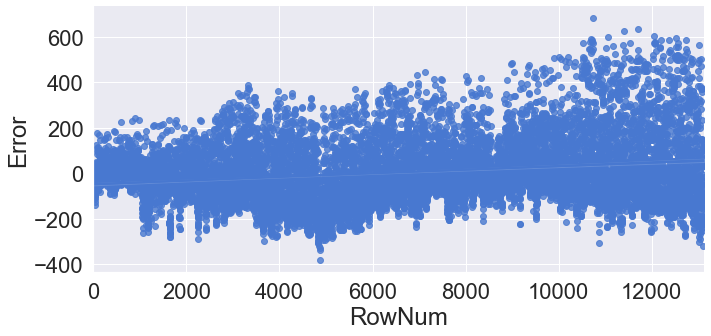

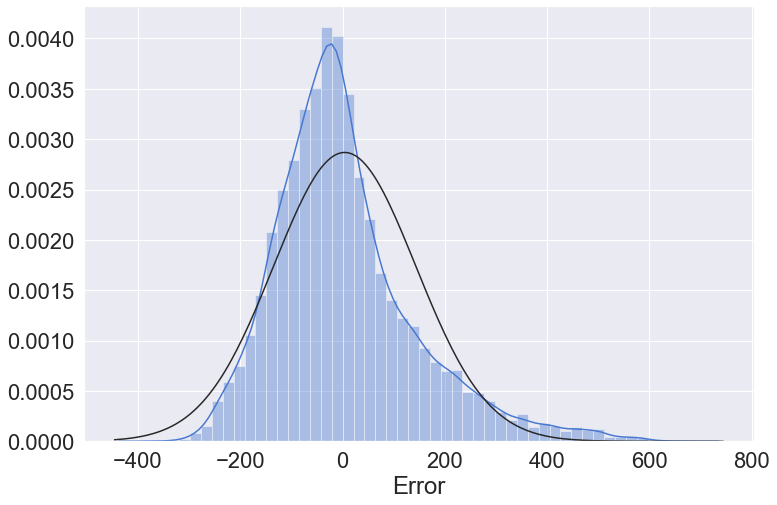

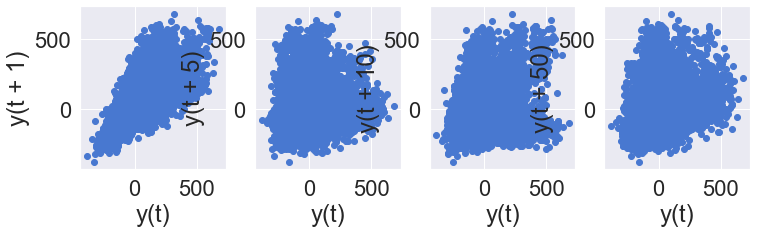

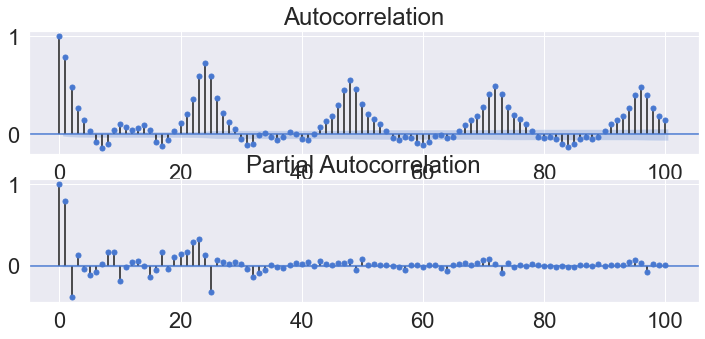

In [130]:
# Data Loading
# location = "https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv"
location = "./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv"
raw_data = pd.read_csv(location)

# Feature Engineering
raw_rd = non_feature_engineering(raw_data)

# Data Split
# Confirm of input and output
y_cols = ["count"]
X_remove = ["datetime", "DateTime", "temp_group", "casual", "registered"]
x_cols = [x for x in raw_rd.columns if x not in y_cols+X_remove]
X_train_rd, X_test_rd, Y_train_rd, Y_test_rd = datasplit_ts(raw_rd, y_cols, x_cols, "2012-07-01")

# Applying Base Model
fit_reg1_rd = sm.OLS(Y_train_rd, X_train_rd).fit()
display(fit_reg1_rd.summary())
pred_tr_reg1_rd = fit_reg1_rd.predict(X_train_rd).values
pred_te_reg1_rd = fit_reg1_rd.predict(X_test_rd).values

# Evaluation
Score_reg1_rd, Resid_tr_reg1_rd, Resid_te_reg1_rd = evaluation_trte(Y_train_rd, pred_tr_reg1_rd, 
                                                                Y_test_rd, pred_te_reg1_rd, graph_on=True)
display(Score_reg1_rd)

# Error Analysis
error_analysis(Resid_tr_reg1_rd, ["Error"], X_train_rd, graph_on=True)

## Code Summary (Feature Engineering Data)

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:23:53   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.828
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.98,0.09,0.01,0.00,0.01,0.03,0.10,0.00
p-value,0.00,0.10,0.00,0.98,1.00,1.00,1.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,845.57",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


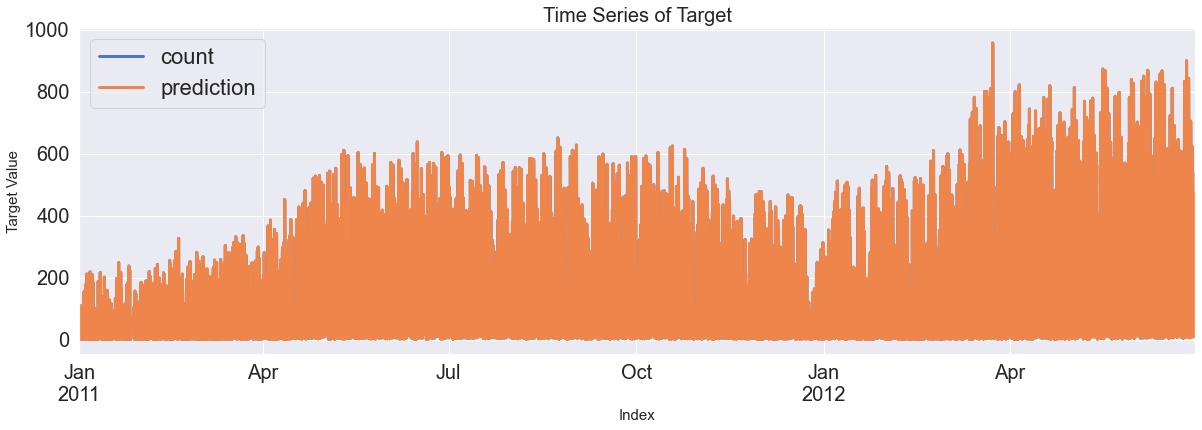

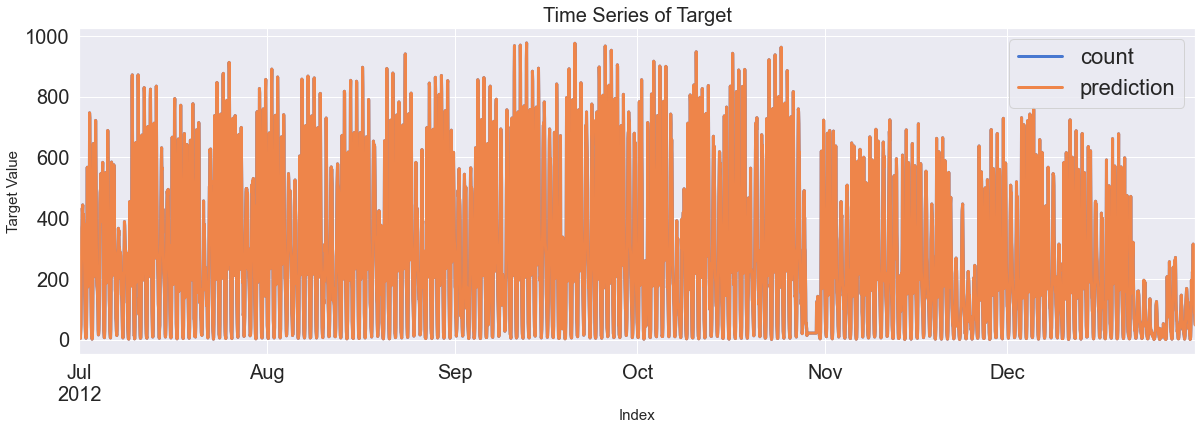

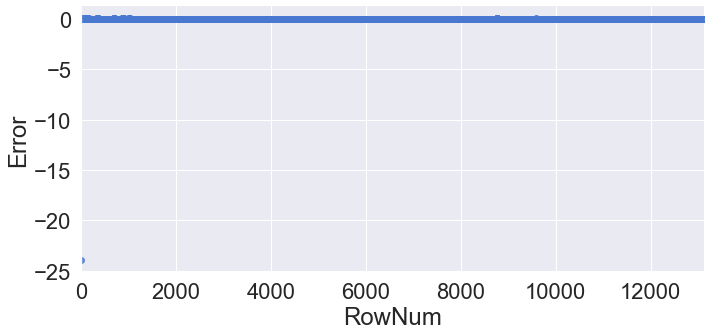

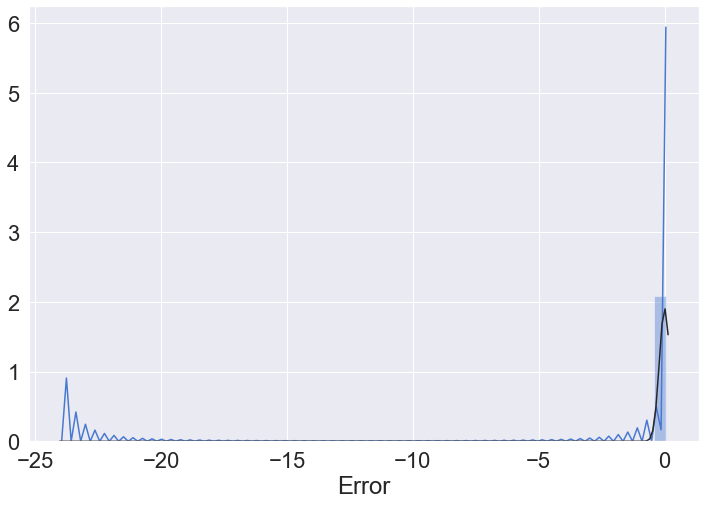

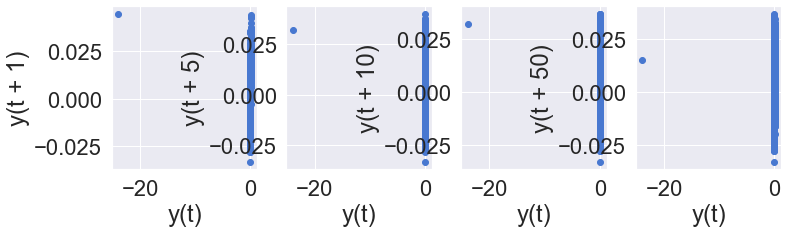

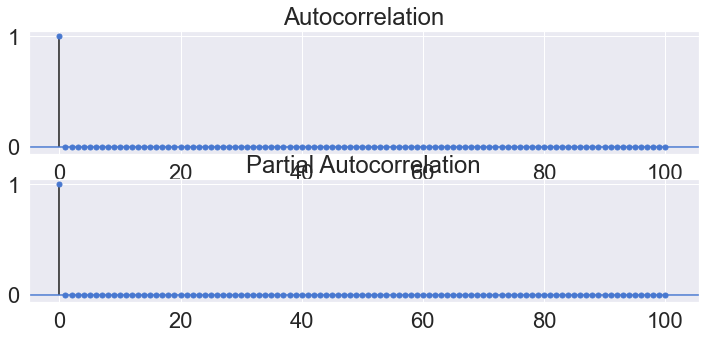

In [131]:
# Data Loading
# location = "https://raw.githubusercontent.com/cheonbi/DataScience/master/Data/Bike_Sharing_Demand_Full.csv"
location = "./Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv"
raw_data = pd.read_csv(location)

# Feature Engineering
data = feature_engineering(raw_data)

# Data Split
# Confirm of input and output
y_cols = ["count"]
X_remove = ["datetime", "DateTime", "temp_group", "casual", "registered"]
x_cols = [x for x in data.columns if x not in y_cols+X_remove]
X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = datasplit_ts(data, y_cols, x_cols, "2012-07-01")

# Applying Base Model
fit_reg1_fe = sm.OLS(Y_train_fe, X_train_fe).fit()
display(fit_reg1_fe.summary())
pred_tr_reg1_fe = fit_reg1_fe.predict(X_train_fe).values
pred_te_reg1_fe = fit_reg1_fe.predict(X_test_fe).values

# Evaluation
Score_reg1_fe, Resid_tr_reg1_fe, Resid_te_reg1_fe = evaluation_trte(Y_train_fe, pred_tr_reg1_fe,
                                                                Y_test_fe, pred_te_reg1_fe, graph_on=True)
display(Score_reg1_fe)

# Error Analysis
error_analysis(Resid_tr_reg1_fe, ["Error"], X_train_fe, graph_on=True)